In [1]:
from typing import Annotated,Literal
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from typing_extensions import TypedDict

# Basic Agents function

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Load tokenizer and model
model_name = "/home/siamai/data/Focus/agentic/notebooks/model/xlm_routing"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def classify_xlm(text:str):
    dict = {0:"multiple",1:"prediction"}
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits.argmax(dim=1)
    return dict[logits.item()]

# Function with Langgraph

In [78]:
class MessageClassifier(BaseModel):
    message_type: Literal["multiple","prediction"] = Field(
        ...,
        description="Classify if the message is multiple or prediction",
    )

class State(TypedDict):
    message: str
    message_type: str | None

def classify_message(state: State) -> State:
    messsage = state["message"]
    message_type = classify_xlm(messsage)
    validated_type = MessageClassifier(message_type=message_type) 
    return {"message_type":validated_type.message_type}

def router(state: State) -> State:
    message_type = state.get("message_type","default")
    
    if message_type == "multiple":
        return {"next":"multiple"}

    return {"next":"prediction"}

def prediction_agent(state: State) -> State:
    message = state["message"]
    message = f"Hello User I'm a prediction_agent agent!"
    return {"message":[message]}

def multiple_agent(state: State) -> State:
    message = state["message"]
    message = f"Hello User I'm a multiple_agent agent!"
    return {"message":[message]}

graph_builder = StateGraph(State)

graph_builder.add_node("classifier",classify_message)
graph_builder.add_node("router",router)
graph_builder.add_node("prediction_agent",prediction_agent)
graph_builder.add_node("multiple_agent",multiple_agent)

graph_builder.add_edge(START,"classifier")
graph_builder.add_edge("classifier","router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
        "prediction": "prediction_agent",
        "multiple": "multiple_agent"
    }
)
graph_builder.add_edge("prediction_agent",END)
graph_builder.add_edge("multiple_agent",END)
graph = graph_builder.compile()

In [90]:
#randomly select row from dataframe as input
import pandas as pd

df = pd.read_csv("/home/siamai/data/Focus/agentic/data/test.csv")
user_input = df.sample(n=1).iloc[0]["query"]
print(f"User input: {user_input}")
state = graph.invoke({"message":[user_input]})              
state

User input: ตอบคำถามด้วยตัวเลือกที่เหมาะสม A, B, C และ D กรุณาตอบด้วยคำตอบที่ถูกต้อง A, B, C หรือ D เท่านั้น ห้ามใช้คำฟุ่มเฟือยหรือให้ข้อมูลเพิ่มเติม

คำถาม: เมื่อมีธุรกิจล้มเหลวและอัตราการว่างงานสูง วงจรธุรกิจจะอยู่ในช่วงใด

ตัวเลือก: A: การขยายตัว, B: จุดสูงสุด, C: การฟื้นตัว, D: จุดต่ำสุด

คำตอบ:


{'message': ["Hello User I'm a multiple_agent agent!"],
 'message_type': 'multiple'}

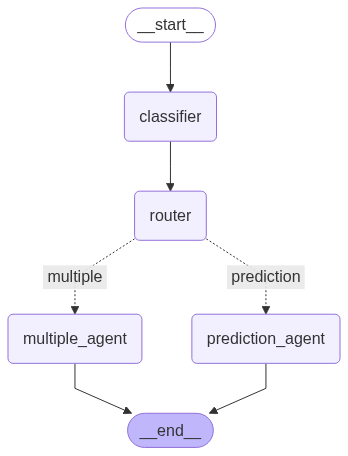

In [80]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png(max_retries=10)))

In [ ]:
# !kaggle competitions submit -c financial-analysis-agent -f /home/siamai/data/Penguin/week8/baseline.csv -m "Typhoon-8b-zeroshot-cleaned"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████████████████████████████████| 19.3k/19.3k [00:00<00:00, 22.6kB/s]
Successfully submitted to Financial Analysis Agent Hackathon